In [2]:
from mewpy.io import Reader, Engines, read_model, read_json
from mewpy.germ.analysis import get_real_initial_state, ifva, SRFBA, FBA
import pandas as pd
import os
import numpy as np
import re

In [3]:
import re

In [4]:
sbml_fname = "..\\data\\organ_atlas\\female\\Colon.xml"
male_sbml_fname = "..\\data\\organ_atlas\\male\\Colon.xml"
trn_fname = "..\\data\\pypath\\grouped_sirt1_trn_manually_curated.csv"

In [5]:
recon_reader = Reader(Engines.MetabolicSBML, sbml_fname)
male_recon_reader = Reader(Engines.MetabolicSBML, male_sbml_fname)
trn_reader = Reader(Engines.BooleanRegulatoryCSV,
                            trn_fname, sep=',', id_col=0, rule_col=1, header=0)
female_colon = read_model(recon_reader, trn_reader)
male_colon = read_model(male_recon_reader, trn_reader)

In [6]:
female_colon.objective = {"biomass_maintenance":1.0}
male_colon.objective = {"biomass_maintenance":1.0}

In [35]:
female_colon.get("biomass_maintenance").bounds = (1,1)
male_colon.get("biomass_maintenance").bounds = (1,1)

In [83]:
for rxn in female_colon.reactions.keys():
    rxn_name = rxn
    if re.search("sink", rxn_name):
        print(rxn_name, female_colon.get(rxn_name).bounds)

sink_Ser_Gly_Ala_X_Gly[r] (-1000.0, 1000.0)
sink_avite1[c] (0.0, 1000.0)
sink_btn[c] (0.0, 1000.0)
sink_fe3[c] (0.0, 1000.0)
sink_pydx[c] (0.0, 1000.0)
sink_pydxn[c] (0.0, 1000.0)
sink_retinol[c] (0.0, 1000.0)
sink_thf[c] (0.0, 1000.0)
sink_thmpp[c] (0.0, 1000.0)


In [78]:
male_colon

Model,COBRAModel
Name,Model Exported from COBRA Toolbox
Types,"regulatory, metabolic"
Compartments,"bc, bp, bpC, c, e, g, i, l, luC, luLI, m, n, r, u, x"
Reactions,6651
Metabolites,4444
Genes,1869
Exchanges,410
Demands,53
Sinks,706
Objective,biomass_maintenance


In [7]:
import pandas as pd

In [1]:
diets = pd.read_excel("..\\data\\diets\\NewDiets.xlsx").set_index("Index")

NameError: name 'pd' is not defined

In [ ]:
diet = diets.to_dict()["High-fat diet"]

In [2]:
for rxn in female_colon.reactions.keys():
    rxn_name = rxn
    if re.search(r"^EX", rxn_name):
        if re.search(r"\[luLI\]$", rxn_name) or re.search(r"\[bp\]$", rxn_name):
            model_reaction = female_colon.get(rxn_name)
            if rxn_name in diet:
                model_reaction.bounds = (-1 * diet[rxn_name], 1000)
            else:
                model_reaction.bounds = (-0.5, 1000)
        elif re.search(r"\[bc\]$", rxn_name):
            model_reaction = female_colon.get(rxn_name)
            model_reaction.bounds = (-0.5, 1000)
        else:
            model_reaction = female_colon.get(rxn_name)
            model_reaction.bounds = (-1000, 1000)

NameError: name 'female_colon' is not defined

In [39]:
for rxn in male_colon.reactions.keys():
    rxn_name = rxn
    if re.search(r"^EX", rxn_name):
        if re.search(r"\[luLI\]$", rxn_name) or re.search(r"\[bp\]$", rxn_name):
            model_reaction = male_colon.get(rxn_name)
            if rxn_name in diet:
                model_reaction.bounds = (-1 * diet[rxn_name], 1000)
            else:
                model_reaction.bounds = (-0.5, 1000)
        elif re.search(r"\[bc\]$", rxn_name):
            model_reaction = male_colon.get(rxn_name)
            model_reaction.bounds = (-0.5, 1000)
        else:
            model_reaction = male_colon.get(rxn_name)
            model_reaction.bounds = (-1000, 1000)

In [40]:
female_srfba = SRFBA(female_colon).build()

In [41]:
male_srfba = SRFBA(male_colon).build()

In [42]:
microbiome_fluxes = pd.read_excel("..\\data\\infant_microbiomes\\microbiome_fluxes_recon3d.xlsx").set_index("Index")

In [43]:
microbiome_fluxes = microbiome_fluxes.loc["Butyrate"].to_dict()

In [44]:
metadata = pd.read_excel("..\\data\\infant_microbiomes\\43856_2024_715_MOESM7_ESM.xlsx", header=3).set_index("Sample ID")

In [45]:
results = {}
for sample, butyrate_flux in microbiome_fluxes.items():
    print("Sample:", sample, "butyrate flux:", butyrate_flux)
    sirt1_expression = max(0, -6.116 * butyrate_flux + 0.945)
    print("Sirt1 Expression = ", sirt1_expression)
    if metadata.loc[sample].Gender == 'Female':
        model = female_colon
        srfba_model = female_srfba
        print("Female")
    elif metadata.loc[sample].Gender == 'Male':
        model = male_colon
        srfba_model = male_srfba
        print("Male")
    else:
        model = None
    if model:
        real_initial_state = get_real_initial_state(model, initial_state={"SIRT1": sirt1_expression}, strategy="mean")
        sol = srfba_model.optimize(initial_state = real_initial_state)
        print("Solution =",sol.objective_value)
    
        results[sample] = sol.to_series()
    else:
        print("Sample",sample,"does not have a valid Gender!")
    print("----------------------------------")

Sample: V3_C005 butyrate flux: 0.003893040293040293
Sirt1 Expression =  0.9211901655677656
Male
Solution = 1.0
----------------------------------
Sample: V3_C009 butyrate flux: 0.0
Sirt1 Expression =  0.945
Female
Solution = 1.0
----------------------------------
Sample: V3_C010 butyrate flux: 0.0
Sirt1 Expression =  0.945
Female
Solution = 1.0
----------------------------------
Sample: V3_C016 butyrate flux: 0.0
Sirt1 Expression =  0.945
Male
Solution = 1.0
----------------------------------
Sample: V3_C018 butyrate flux: 0.0
Sirt1 Expression =  0.945
Female
Solution = 1.0
----------------------------------
Sample: V3_C019 butyrate flux: 0.0025463372093023256
Sirt1 Expression =  0.9294266016279069
Male
Solution = 1.0
----------------------------------
Sample: V3_C100 butyrate flux: 0.0
Sirt1 Expression =  0.945
Female
Solution = 1.0
----------------------------------
Sample: V3_C101 butyrate flux: 0.03131871640866878
Sirt1 Expression =  0.7534547304445817
Male
Solution = 1.0
---------

In [46]:
generic_sbml_fname = "..\\data\\models\\sirt1_recon3d\\Recon3D_SIRT1_generic_gpr_fix.xml"
generic_recon_reader = Reader(Engines.MetabolicSBML, generic_sbml_fname)
generic_model = read_model(generic_recon_reader, trn_reader)

In [47]:
reactions = []
for reaction in generic_model.reactions.keys():
    model_reaction = generic_model.get(reaction)
    if not "target" in model_reaction.types:
        reactions.append(reaction)

In [48]:
import pandas as pd

# Step 1: Use the full reactions list directly
all_reactions = list(reactions)  # Ensure it's a list

# Step 2: Create an empty DataFrame with reactions as columns
df = pd.DataFrame(index=results.keys(), columns=all_reactions).fillna(0.0)

# Step 3: Fill in only those reactions that exist in both the Series and reactions list
for key, series in results.items():
    filtered_series = series[series.index.isin(all_reactions)]
    df.loc[key, filtered_series.index] = filtered_series.values

In [49]:
# Z-score normalize each column (reaction)
df_scaled = (df - df.mean()) / df.std()
df_scaled = df_scaled.fillna(0.0)  # Handle columns with 0 std

In [58]:
df_scaled = df_scaled.loc[:, df_scaled.nunique() > 1]

In [63]:
# 2. Calculate variance of each reaction
reaction_variance = df_scaled.var(axis=0)

# 3. Select top N most variable reactions
top_n = 100  # You can adjust this to 50, 200, etc.
top_reactions = reaction_variance.sort_values(ascending=False).head(top_n).index

# 4. Filter normalized DataFrame
df_top = df_scaled[top_reactions]

In [74]:
top_reactions = reaction_variance[reaction_variance < 0.99999999].index
df_top = df_scaled[top_reactions]

C:\Users\Jordi\miniconda3\envs\cobrapy\lib\site-packages\seaborn\matrix.py:623: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


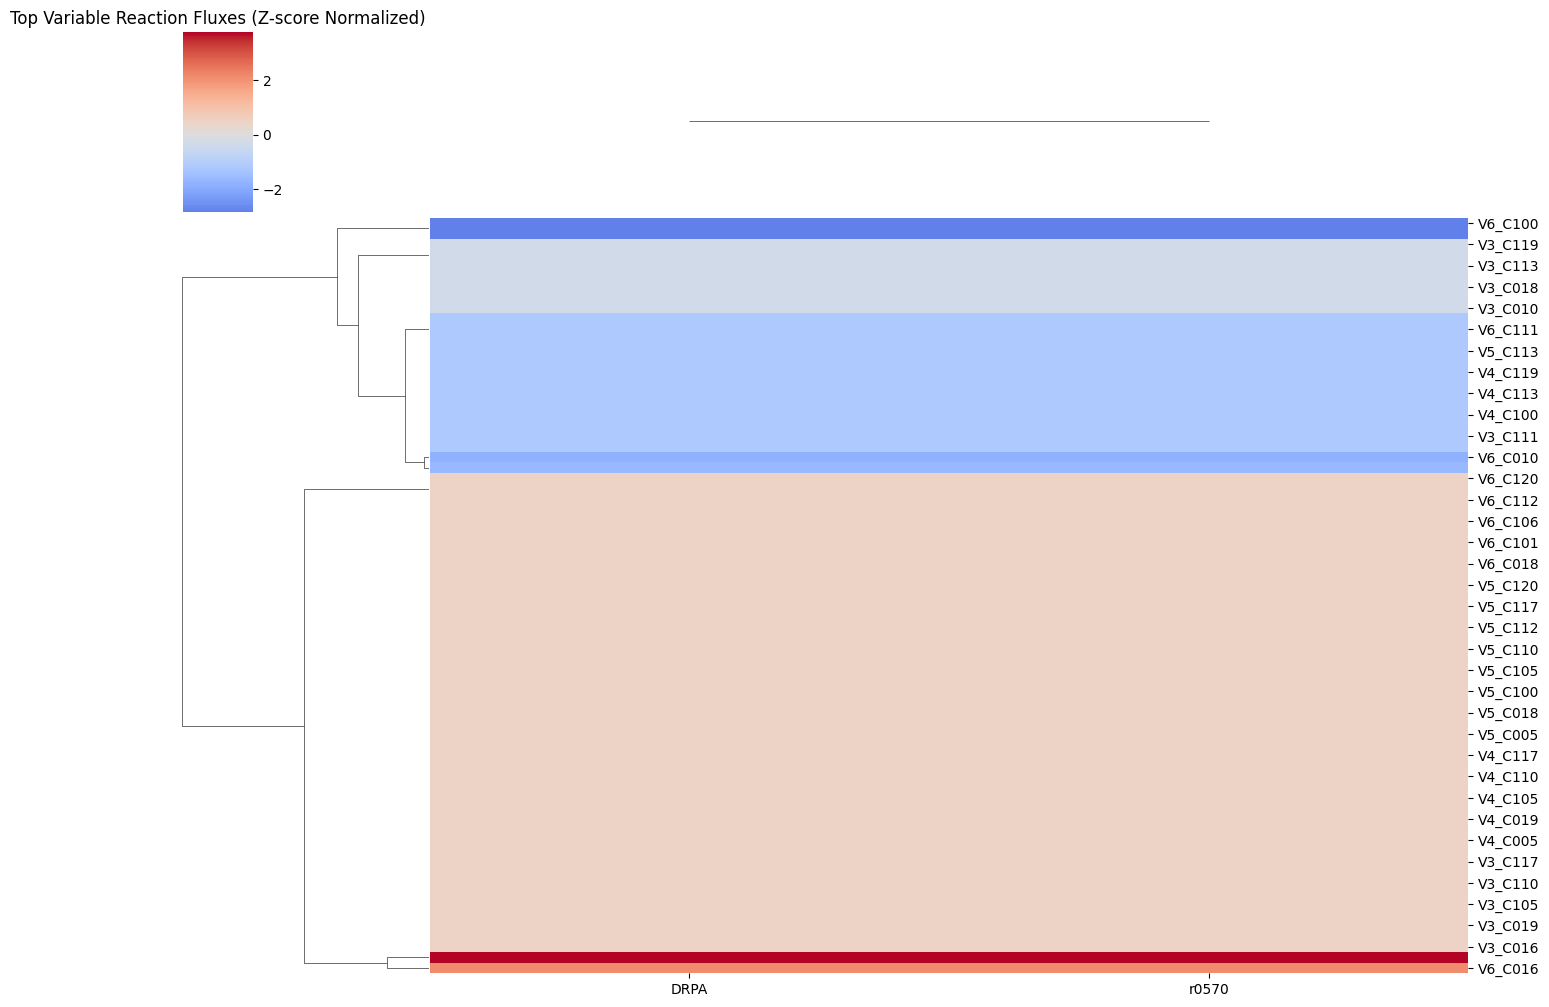

In [75]:
# 5. Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(df_top, metric='euclidean', method='ward', cmap='coolwarm', figsize=(14, 10), center=0)
plt.title("Top Variable Reaction Fluxes (Z-score Normalized)")
plt.show()


C:\Users\Jordi\miniconda3\envs\cobrapy\lib\site-packages\seaborn\matrix.py:623: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


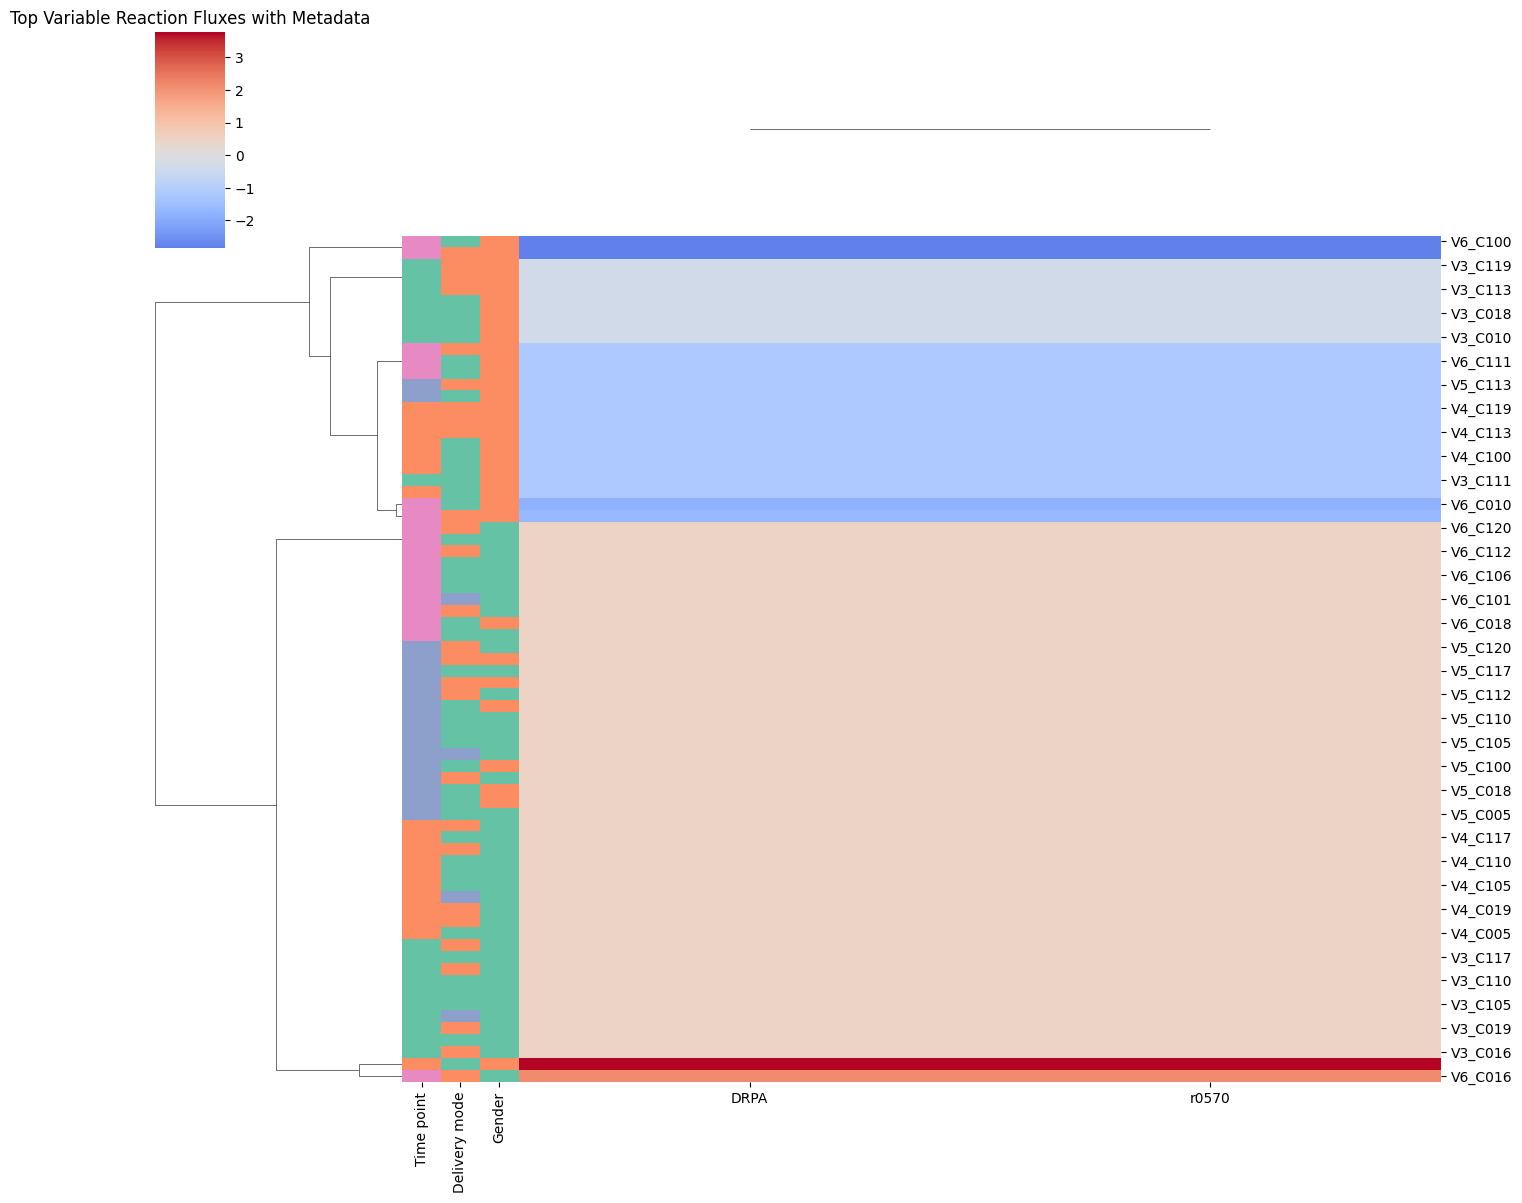

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Make sure the index matches the flux DataFrame
metadata = metadata.loc[df_top.index]  # Align samples

# 2. Select metadata variables
meta_vars = ['Time point', 'Delivery mode', 'Gender']
meta_colors = {}

# 3. Assign a unique color to each category value
for var in meta_vars:
    unique_vals = metadata[var].dropna().unique()
    palette = sns.color_palette("Set2", n_colors=len(unique_vals))
    meta_colors[var] = dict(zip(unique_vals, palette))

# 4. Create a DataFrame of row_colors
row_colors = pd.DataFrame({
    var: metadata[var].map(meta_colors[var])
    for var in meta_vars
}, index=metadata.index)

# 5. Plot heatmap with annotations
sns.clustermap(
    df_top,
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    figsize=(14, 12),
    center=0,
    row_colors=row_colors
)

plt.title("Top Variable Reaction Fluxes with Metadata")
plt.show()


In [241]:
initial_state = get_real_initial_state(female_colon, initial_state={"SIRT1": 0.1}, strategy="mean")

In [242]:
sol = srfba.optimize(initial_state=initial_state)

In [243]:
sol

Method,SRFBA
Model,Model COBRAModel - Model Exported from COBRA Toolbox
Objective,biomass_maintenance
Objective value,1.0983963604008422
Status,optimal


In [235]:
fba_model = FBA(female_colon).build()

In [236]:
sol = fba_model.optimize()

In [237]:
sol

Method,FBA
Model,Model COBRAModel - Model Exported from COBRA Toolbox
Objective,biomass_maintenance
Objective value,1.2507981070251457
Status,optimal


In [69]:
from cobra.io import read_sbml_model

In [70]:
cobra_model = read_sbml_model(sbml_fname)

In [72]:
cobra_model

Name,COBRAModel
Memory address,2b839bf3a60
Number of metabolites,4439
Number of reactions,6622
Number of genes,1868
Number of groups,92
Objective expression,1.0*biomass_reaction - 1.0*biomass_reaction_reverse_32a6c
Compartments,"Cytoplasm, Mitochondrion, Extracellular, Nucleus, Endoplasmic_reticulum, Golgi, Peroxisome, Lysosome, unknownCompartment7, unknownCompartment9, unknownCompartment3, unknownCompartment10, unknownCompartment2, unknownCompartment1, Unknown"


In [71]:
cobra_model.optimize()

,fluxes,reduced_costs
10FTHFtm,0.0,0.0
13DAMPPOX,0.0,0.0
2AMACSULT,0.0,0.0
2HBO,0.0,0.0
2HBt2,0.0,0.0
...,...,...
EX_tma[bp],0.0,0.0
EX_tma[luLI],0.0,0.0
EX_ura[bp],-0.0,0.0
EX_uri[bp],-0.0,0.0


In [84]:
# 1. Remove columns with zero variance BEFORE scaling
original_variance = df.var(axis=0)
df_filtered = df.loc[:, original_variance > 0]

# 2. Now safely apply z-score normalization (or whatever scaling)
df_scaled = (df_filtered - df_filtered.mean()) / df_filtered.std()
df_scaled = df_scaled.fillna(0.0)

In [118]:
# Separate sample IDs
male_samples = metadata[metadata["Gender"] == "Male"].index
female_samples = metadata[metadata["Gender"] == "Female"].index

# Function to check if values are constant within each group
def is_constant_within_groups(col):
    male_vals = df_filtered.loc[male_samples, col]
    female_vals = df_filtered.loc[female_samples, col]
    return male_vals.nunique() == 1 and female_vals.nunique() == 1

# Make sure to operate on axis=1 (columns) and pass column names explicitly
constant_within_groups = [
    col for col in df_filtered.columns
    if df_filtered.loc[male_samples, col].nunique() == 1 or df_filtered.loc[female_samples, col].nunique() == 1
]

# Drop those columns from the dataframe
df_variable_within_group = df_filtered.drop(columns=constant_within_groups)

# Optional: print how many were dropped
print(f"Dropped {len(constant_within_groups)} reactions with constant values within each gender group.")

Dropped 589 reactions with constant values within each gender group.


In [119]:
df_variable_within_group

,10FTHFtm,4ABUTtm,A_MANASEly,ABTArm,ACCOACm,ACGALtly,ACGAMK,ACGAMtly,ACNAMlt,ACNMLr,...,HMR_2089,HMR_2090,HMR_2602,HMR_2603,HMR_2604,HMR_2884,HMR_2886,HMR_3106,HMR_3831,HMR_3859
V3_C005,-1.833345,-1.729551,0.734437,-1.729551,3.086717,0.078810,10.064243,8.250996,-1.313247,1.813247,...,489.754295,489.754295,0.704960,0.704960,-0.704960,-1.500000,1.500000,998.328797,1.353786,1.714322
V3_C009,-4.000017,-18.979049,0.711000,-18.979049,19.782616,0.160500,21.408000,16.876000,-2.871500,4.532000,...,478.843250,478.843250,2.070833,2.070833,-2.070833,-1.070833,1.070833,1000.000000,17.316663,3.530000
V3_C010,-4.000017,-18.979049,0.711000,-18.979049,19.782616,0.160500,21.408000,16.876000,-2.871500,4.532000,...,478.843250,478.843250,2.070833,2.070833,-2.070833,-1.070833,1.070833,1000.000000,17.316663,3.530000
V3_C016,-1.833345,-1.691070,0.732273,-1.691070,3.084793,0.055000,10.003636,8.216364,-1.287273,1.787273,...,489.876591,489.876591,0.706884,0.706884,-0.706884,-1.500000,1.500000,998.307633,1.392266,1.787435
V3_C018,-4.000017,-18.979049,0.711000,-18.979049,19.782616,0.160500,21.408000,16.876000,-2.871500,4.532000,...,478.843250,478.843250,2.070833,2.070833,-2.070833,-1.070833,1.070833,1000.000000,17.316663,3.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V6_C113,-3.736216,-19.316663,0.750302,-19.316663,19.843942,0.376662,22.508461,17.504835,-3.126964,5.003626,...,477.300639,477.300639,2.070833,2.070833,-2.070833,-1.270833,1.270833,999.800000,17.316663,2.635457
V6_C114,-3.753985,-19.316663,0.768260,-19.316663,19.750021,0.475428,23.011272,17.792155,-3.243688,5.219117,...,476.595806,476.595806,2.070833,2.070833,-2.070833,-1.261234,1.261234,999.809599,17.316663,2.384806
V6_C117,-1.916671,-2.249997,0.594056,-2.249997,2.750003,0.233327,9.269650,7.572937,-1.196713,1.696713,...,490.237642,490.237642,0.804970,0.804970,-0.804970,-1.677459,1.677459,996.932736,1.249997,0.666663
V6_C119,-3.907797,-19.316663,0.795578,-19.316663,18.608586,0.796712,24.369619,18.183904,-3.592290,6.185715,...,475.055806,475.055806,2.070833,2.070833,-2.070833,-1.105400,1.105400,999.965433,17.316663,1.199658


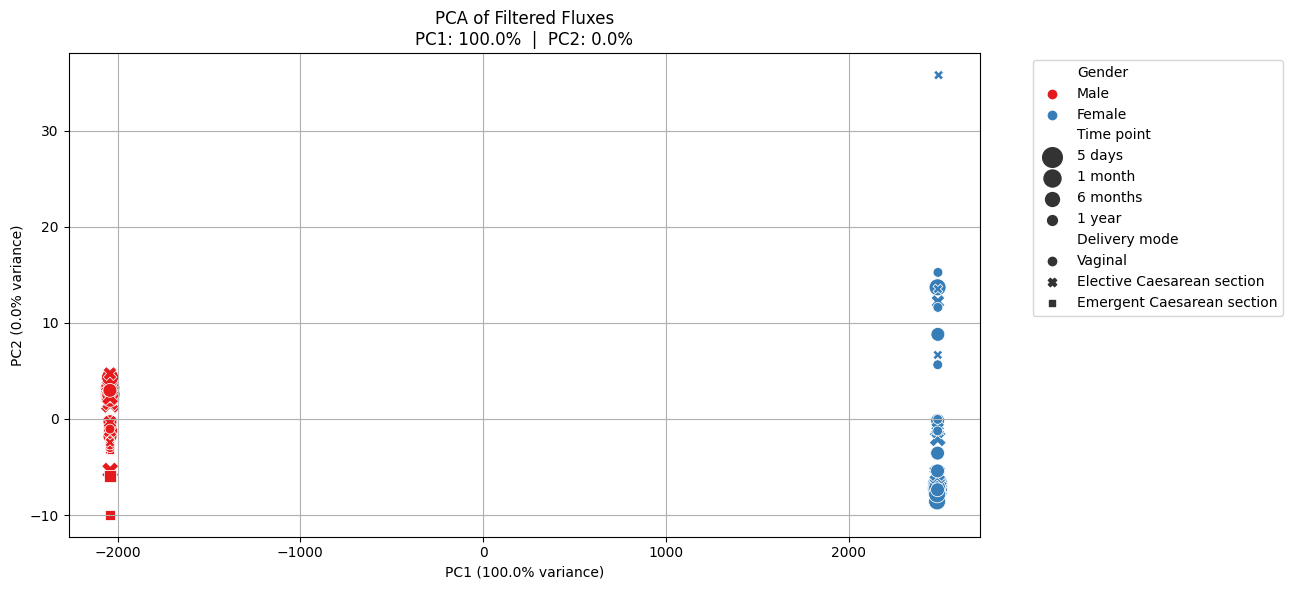

In [120]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure metadata is aligned
metadata_subset = metadata.loc[df_variable_within_group.index]

# Step 2: Run PCA on the filtered flux matrix
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_variable_within_group)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=df_variable_within_group.index)

# Step 3: Merge with metadata for plotting
pca_df = pca_df.join(metadata_subset[['Gender', 'Delivery mode', 'Time point']])

# Step 4: Plot using seaborn with annotations
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Gender',
    style='Delivery mode',
    size='Time point',  # Optional — will auto-map time point labels
    palette='Set1',
    sizes=(50, 200),
)

# Labeling and formatting
plt.title(f"PCA of Filtered Fluxes\nPC1: {pca.explained_variance_ratio_[0]*100:.1f}%  |  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


C:\Users\Jordi\miniconda3\envs\cobrapy\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


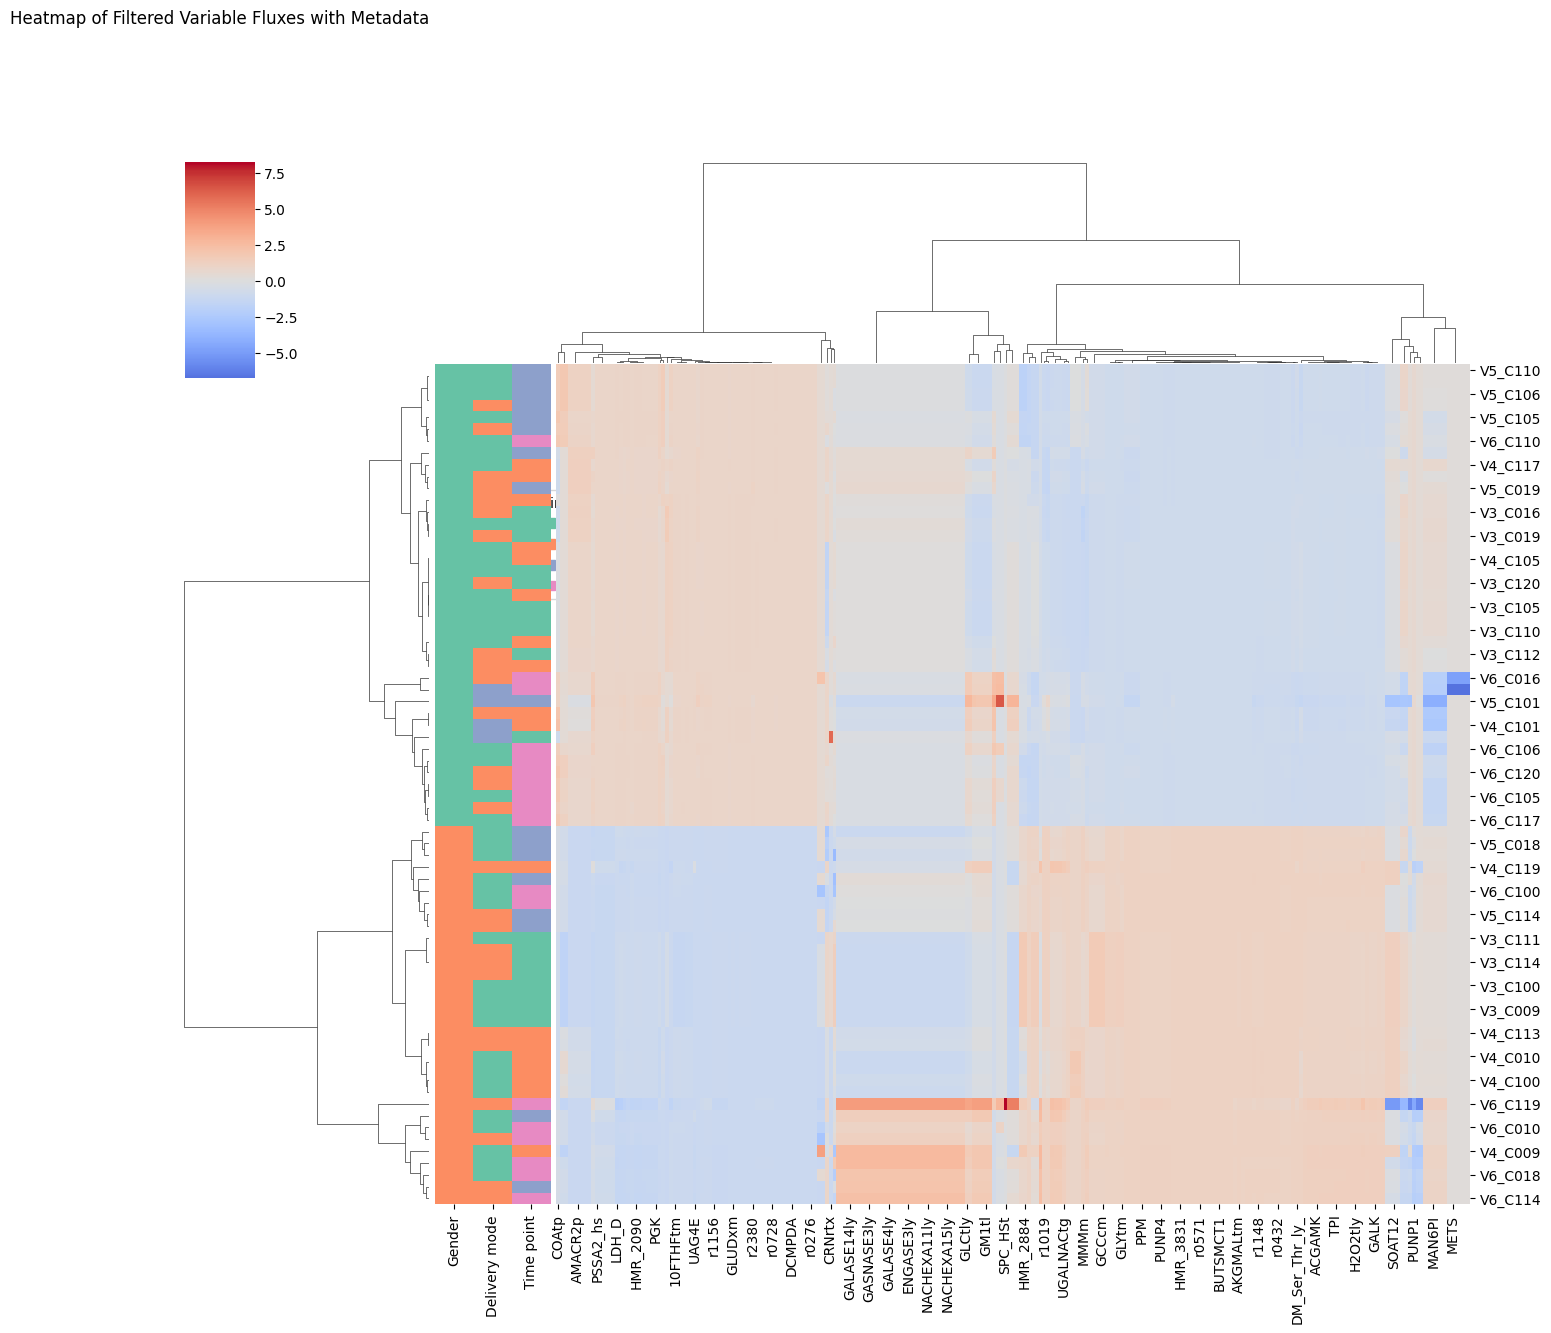

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Filter top N most variable reactions
raw_variance = df_variable_within_group.var(axis=0)
top_n = 235  # You can adjust
top_reactions = raw_variance.sort_values(ascending=False).head(top_n).index
df_top = df_variable_within_group[top_reactions]

# Step 2: Z-score normalization (per column)
df_scaled = (df_top - df_top.mean()) / df_top.std()
df_scaled = df_scaled.fillna(0.0)

# Step 3: Align metadata
metadata_subset = metadata.loc[df_scaled.index]
meta_vars = ['Gender', 'Delivery mode', 'Time point']
meta_colors = {}

for var in meta_vars:
    unique_vals = metadata_subset[var].dropna().unique()
    palette = sns.color_palette("Set2", n_colors=len(unique_vals))
    meta_colors[var] = dict(zip(unique_vals, palette))

row_colors = pd.DataFrame({
    var: metadata_subset[var].map(meta_colors[var])
    for var in meta_vars
}, index=metadata_subset.index)

# Step 4: Create the heatmap with clustering
g = sns.clustermap(
    df_scaled,
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    center=0,
    figsize=(14, 12),
    row_colors=row_colors
)

# Step 5: Add manual legends
for idx, var in enumerate(meta_vars):
    handles = [
        mpatches.Patch(color=color, label=label)
        for label, color in meta_colors[var].items()
    ]
    g.ax_row_dendrogram.legend(
        handles=handles,
        title=var,
        bbox_to_anchor=(1.0 + 0.18 * idx, 0.85),
        loc='upper left',
        borderaxespad=0.
    )

plt.title("Heatmap of Filtered Variable Fluxes with Metadata", pad=100)
plt.show()
